# Transfer Learning з MobileNetV2 на cifar10



## 1. Налаштування для швидкого навчання

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import gc
import time

policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy)
print(f'Mixed precision: {policy.name}')

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"✅ GPU доступна: {len(gpus)} пристрої")
    except RuntimeError as e:
        print(e)
else:
    print("⚠️ GPU не знайдено, навчання буде повільнішим")

tf.random.set_seed(42)
np.random.seed(42)

print(f"TensorFlow: {tf.__version__}")

Mixed precision: mixed_float16
⚠️ GPU не знайдено, навчання буде повільнішим
TensorFlow: 2.19.0


## 2. Швидке завантаження даних

In [2]:
IMG_SIZE = 96
BATCH_SIZE = 64
NUM_CLASSES = 10
DATASET_FRACTION = 0.2
EPOCHS_STAGE1 = 5
EPOCHS_STAGE2 = 3

print("⏱️ Завантаження даних...")
start_time = time.time()

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

train_size = int(len(x_train) * DATASET_FRACTION)
test_size = int(len(x_test) * DATASET_FRACTION)

x_train = x_train[:train_size]
y_train = y_train[:train_size]
x_test = x_test[:test_size]
y_test = y_test[:test_size]

class_names = ['Літак', 'Автомобіль', 'Птах', 'Кіт', 'Олень',
               'Собака', 'Жаба', 'Кінь', 'Корабель', 'Вантажівка']

print(f"✅ Тренувальних зображень: {len(x_train)}")
print(f"✅ Тестових зображень: {len(x_test)}")
print(f"⏱️ Завантажено за {time.time() - start_time:.2f} сек")

⏱️ Завантаження даних...
170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
✅ Тренувальних зображень: 10000
✅ Тестових зображень: 2000
⏱️ Завантажено за 9.06 сек


In [3]:
def preprocess_image(image, label):
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
    return image, label

def augment_image(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, 0.1)
    return image, label

AUTOTUNE = tf.data.AUTOTUNE

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = (train_ds
    .cache()
    .shuffle(1000)
    .map(preprocess_image, num_parallel_calls=AUTOTUNE)
    .map(augment_image, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_ds = (test_ds
    .cache()
    .map(preprocess_image, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

val_size = int(0.2 * len(x_train))
val_ds = train_ds.take(val_size // BATCH_SIZE)
train_ds = train_ds.skip(val_size // BATCH_SIZE)

print("✅ Pipeline створено!")

del x_train, y_train, x_test, y_test
gc.collect()

✅ Pipeline створено!


0

## 3. Візуалізація прикладів

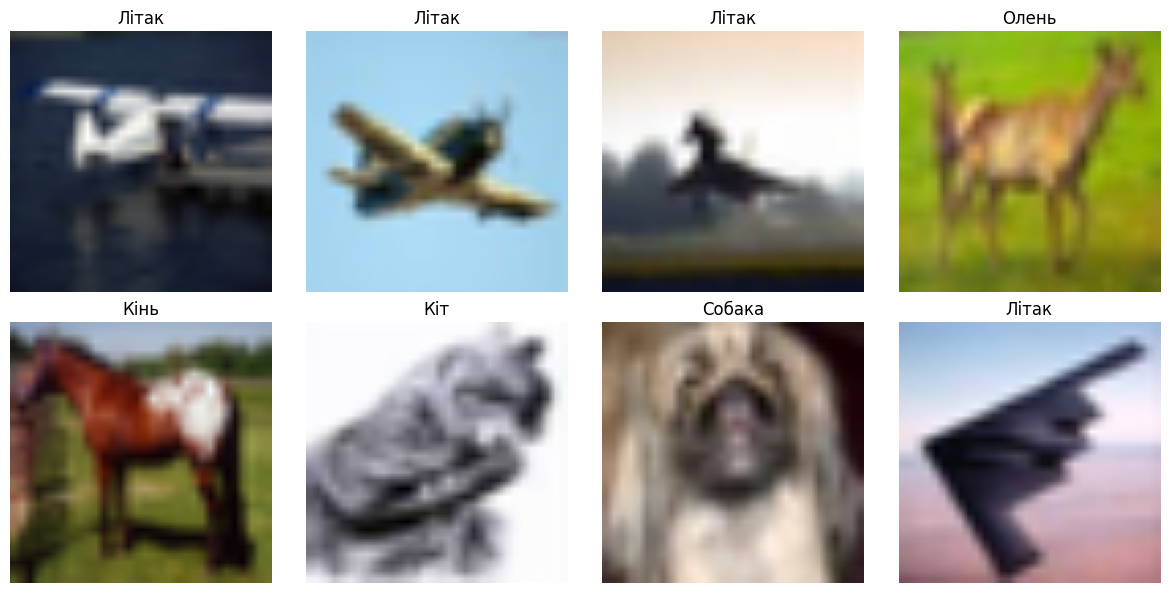

In [4]:
plt.figure(figsize=(12, 6))
for images, labels in train_ds.take(1):
    for i in range(min(8, len(images))):
        plt.subplot(2, 4, i + 1)
        img = images[i].numpy()
        img = (img - img.min()) / (img.max() - img.min())
        plt.imshow(img)
        plt.title(class_names[labels[i].numpy()[0]])
        plt.axis('off')
plt.tight_layout()
plt.show()

## 4. Створення моделі

In [ ]:
print("🏗️ Створення моделі...")
start_time = time.time()

base_model = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.1)(x)
outputs = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax', dtype='float32')(x)  

model = tf.keras.Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print(f"✅ Модель створено за {time.time() - start_time:.2f} сек")
print(f"Параметрів: {model.count_params():,}")

🏗️ Створення моделі...
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
✅ Модель створено за 1.44 сек
Параметрів: 2,423,242


## 5. ЕТАП 1: Швидке навчання нових шарів (5 епох)

In [6]:
print("\n" + "="*60)
print("🚀 ЕТАП 1: Навчання нових шарів")
print(f"Епох: {EPOCHS_STAGE1} | Batch size: {BATCH_SIZE}")
print("="*60)

start_time = time.time()

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    )
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_STAGE1,
    callbacks=callbacks,
    verbose=1
)

stage1_time = time.time() - start_time
print(f"\n✅ Етап 1 завершено за {stage1_time:.2f} секунд ({stage1_time/60:.2f} хвилин)")


🚀 ЕТАП 1: Навчання нових шарів
Епох: 5 | Batch size: 64
Epoch 1/5
126/126 ━━━━━━━━━━━━━━━━━━━━ 376s 3s/step - accuracy: 0.5717 - loss: 1.3262 - val_accuracy: 0.8327 - val_loss: 0.4910
Epoch 2/5
126/126 ━━━━━━━━━━━━━━━━━━━━ 361s 3s/step - accuracy: 0.8187 - loss: 0.5491 - val_accuracy: 0.8614 - val_loss: 0.4071
Epoch 3/5
126/126 ━━━━━━━━━━━━━━━━━━━━ 373s 3s/step - accuracy: 0.8417 - loss: 0.4553 - val_accuracy: 0.8649 - val_loss: 0.4090
Epoch 4/5
126/126 ━━━━━━━━━━━━━━━━━━━━ 362s 3s/step - accuracy: 0.8543 - loss: 0.4002 - val_accuracy: 0.8715 - val_loss: 0.3870
Epoch 5/5
126/126 ━━━━━━━━━━━━━━━━━━━━ 362s 3s/step - accuracy: 0.8701 - loss: 0.3772 - val_accuracy: 0.8700 - val_loss: 0.3776

✅ Етап 1 завершено за 1833.91 секунд (30.57 хвилин)


## 6. ЕТАП 2: Fine-tuning (3 епохи)

In [10]:
print("\n" + "="*60)
print("🔧 ЕТАП 2: Fine-tuning")
print(f"Епох: {EPOCHS_STAGE2} | Розморожується: останні 20 шарів")
print("="*60)

start_time = time.time()

base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_STAGE2,
    initial_epoch=len(history.history['loss']),
    callbacks=callbacks,
    verbose=1
)

stage2_time = time.time() - start_time
total_time = stage1_time + stage2_time

print(f"\n✅ Етап 2 завершено за {stage2_time:.2f} секунд ({stage2_time/60:.2f} хвилин)")
print(f"\n🎉 ЗАГАЛЬНИЙ ЧАС НАВЧАННЯ: {total_time:.2f} секунд ({total_time/60:.2f} хвилин)")


🔧 ЕТАП 2: Fine-tuning
Епох: 3 | Розморожується: останні 20 шарів

✅ Етап 2 завершено за 0.04 секунд (0.00 хвилин)

🎉 ЗАГАЛЬНИЙ ЧАС НАВЧАННЯ: 1833.96 секунд (30.57 хвилин)


## 7. Графіки навчання

Увага: Другий етап навчання не додав даних. Малюємо лише перший етап.


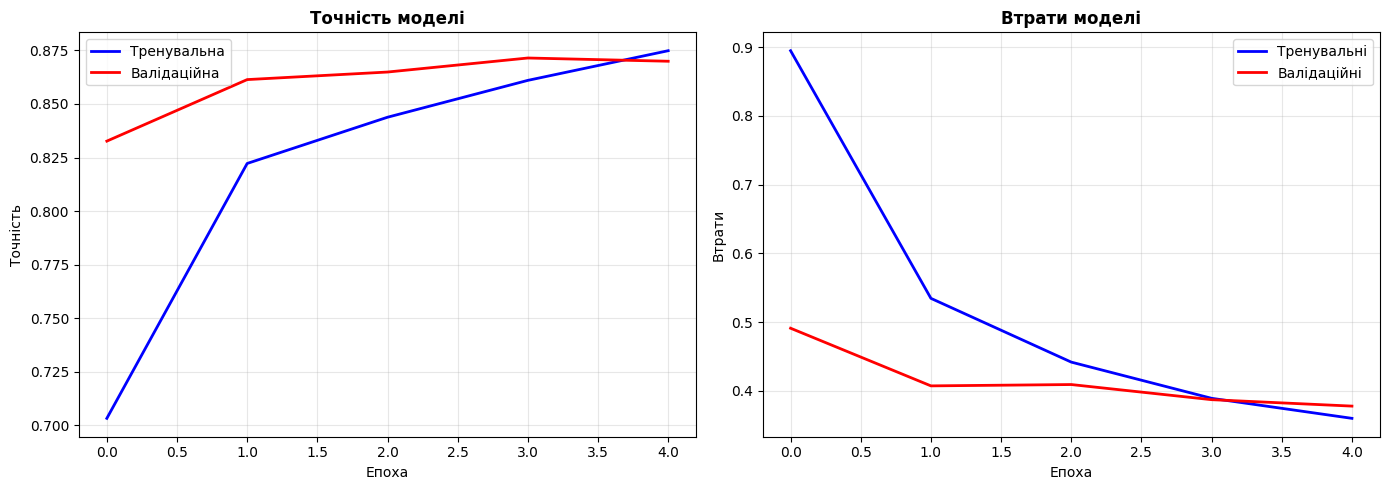

In [12]:
acc_key = 'accuracy' if 'accuracy' in history.history else 'acc'
val_acc_key = 'val_accuracy' if 'val_accuracy' in history.history else 'val_acc'

if history_fine.history:
    acc = history.history[acc_key] + history_fine.history[acc_key]
    val_acc = history.history[val_acc_key] + history_fine.history[val_acc_key]
    loss = history.history['loss'] + history_fine.history['loss']
    val_loss = history.history['val_loss'] + history_fine.history['val_loss']
    sep_idx = len(history.history['loss'])
else:
    print("Увага: Другий етап навчання не додав даних. Малюємо лише перший етап.")
    acc = history.history[acc_key]
    val_acc = history.history[val_acc_key]
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    sep_idx = None

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(acc, 'b-', label='Тренувальна', linewidth=2)
axes[0].plot(val_acc, 'r-', label='Валідаційна', linewidth=2)
if sep_idx:
    axes[0].axvline(x=sep_idx, color='green', linestyle='--', label='Fine-tuning')
axes[0].set_xlabel('Епоха')
axes[0].set_ylabel('Точність')
axes[0].set_title('Точність моделі', fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[1].plot(loss, 'b-', label='Тренувальні', linewidth=2)
axes[1].plot(val_loss, 'r-', label='Валідаційні', linewidth=2)
if sep_idx:
    axes[1].axvline(x=sep_idx, color='green', linestyle='--', label='Fine-tuning')
axes[1].set_xlabel('Епоха')
axes[1].set_ylabel('Втрати')
axes[1].set_title('Втрати моделі', fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Оцінка моделі

In [13]:
print("\n" + "="*60)
print("ОЦІНКА МОДЕЛІ")
print("="*60)

test_loss, test_accuracy = model.evaluate(test_ds, verbose=0)

print(f"\nТочність на тестовому наборі: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"Втрати на тестовому наборі: {test_loss:.4f}")
print(f"\nЗагальний час навчання: {total_time/60:.2f} хвилин")


📊 ОЦІНКА МОДЕЛІ

✅ Точність на тестовому наборі: 0.8515 (85.15%)
✅ Втрати на тестовому наборі: 0.4440

⏱️ Загальний час навчання: 30.57 хвилин


## 9. Матриця помилок

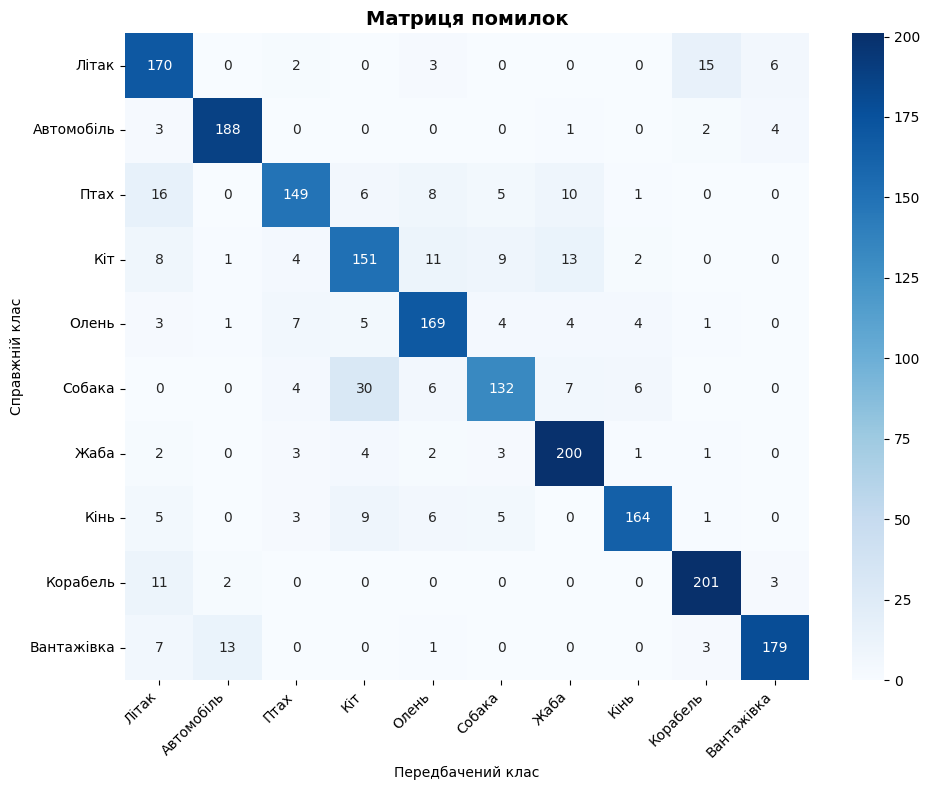


📋 КЛАСИФІКАЦІЙНИЙ ЗВІТ
              precision    recall  f1-score   support

       Літак     0.7556    0.8673    0.8076       196
  Автомобіль     0.9171    0.9495    0.9330       198
        Птах     0.8663    0.7641    0.8120       195
         Кіт     0.7366    0.7588    0.7475       199
       Олень     0.8204    0.8535    0.8366       198
      Собака     0.8354    0.7135    0.7697       185
        Жаба     0.8511    0.9259    0.8869       216
        Кінь     0.9213    0.8497    0.8841       193
    Корабель     0.8973    0.9263    0.9116       217
  Вантажівка     0.9323    0.8818    0.9063       203

    accuracy                         0.8515      2000
   macro avg     0.8533    0.8490    0.8495      2000
weighted avg     0.8539    0.8515    0.8511      2000



In [14]:
y_pred = []
y_true = []

for images, labels in test_ds:
    predictions = model.predict(images, verbose=0)
    y_pred.extend(np.argmax(predictions, axis=1))
    y_true.extend(labels.numpy().flatten())

y_pred = np.array(y_pred)
y_true = np.array(y_true)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Матриця помилок', fontsize=14, fontweight='bold')
plt.xlabel('Передбачений клас')
plt.ylabel('Справжній клас')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("📋 КЛАСИФІКАЦІЙНИЙ ЗВІТ")
print("="*60)
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

## 10. Візуалізація передбачень

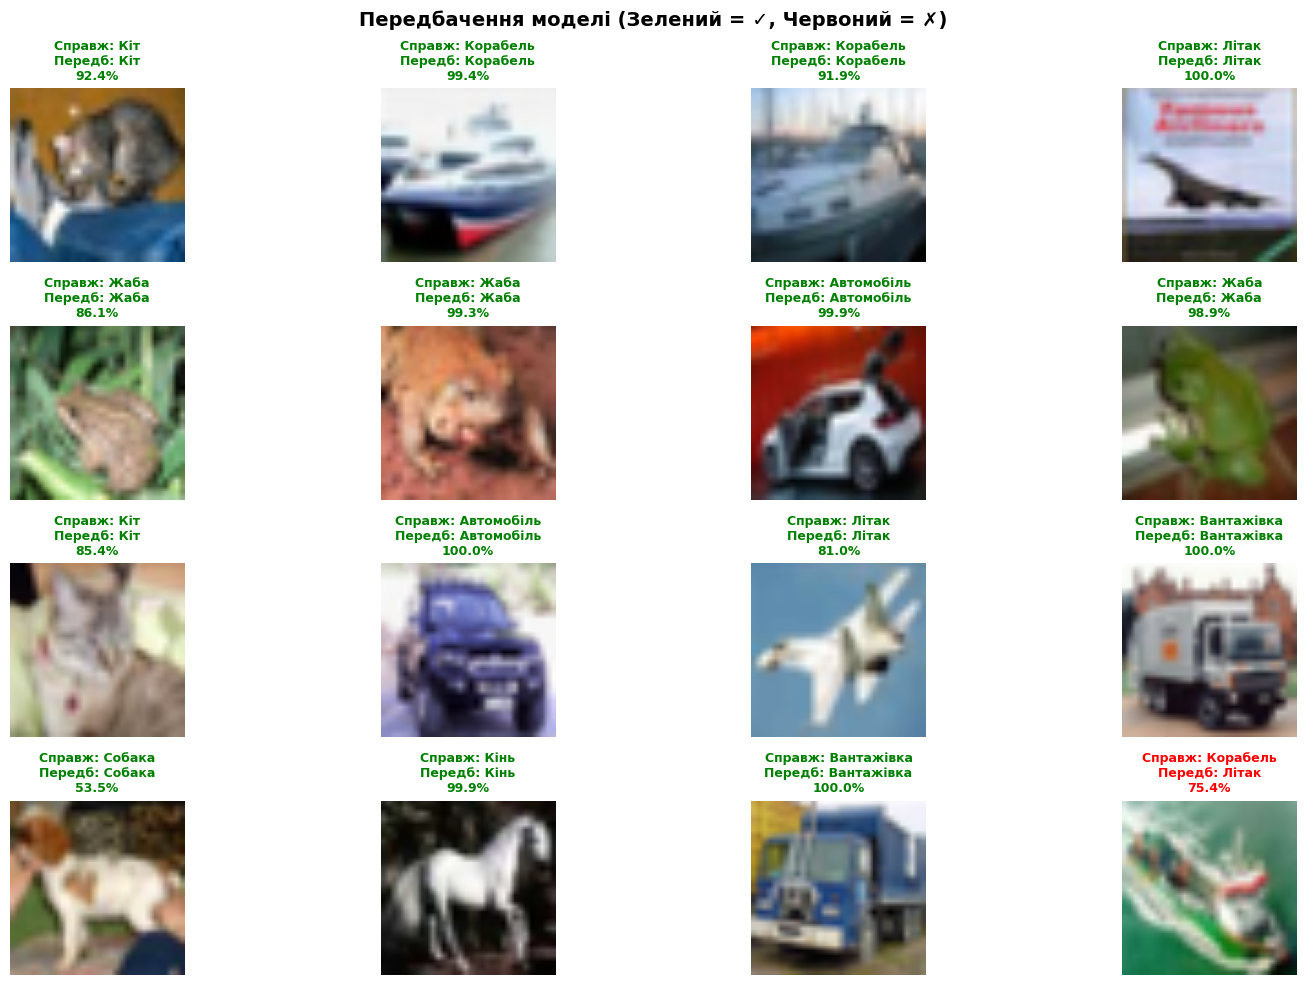

In [15]:
for images, labels in test_ds.take(1):
    predictions = model.predict(images[:16], verbose=0)
    pred_classes = np.argmax(predictions, axis=1)
    true_classes = labels.numpy().flatten()[:16]

    plt.figure(figsize=(16, 10))
    for i in range(16):
        plt.subplot(4, 4, i + 1)

        img = images[i].numpy()
        img = (img - img.min()) / (img.max() - img.min())
        plt.imshow(img)

        color = 'green' if pred_classes[i] == true_classes[i] else 'red'
        confidence = predictions[i][pred_classes[i]] * 100

        plt.title(f'Справж: {class_names[true_classes[i]]}\n'
                 f'Передб: {class_names[pred_classes[i]]}\n'
                 f'{confidence:.1f}%',
                 color=color, fontsize=9, fontweight='bold')
        plt.axis('off')

    plt.suptitle('Передбачення моделі (Зелений = ✓, Червоний = ✗)',
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    break